<a href="https://colab.research.google.com/github/Febri-ElectricalEngineering/CapstoneProject/blob/main/notebooks/02_baseline_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install scikit-learn matplotlib pandas joblib

In [2]:
import os, json
import pandas as pd
from joblib import dump
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

In [3]:
TRAIN = "data/bbc_cls/train.csv"
TEST  = "data/bbc_cls/test.csv"

In [6]:
import os, shutil
from pathlib import Path

os.makedirs('data/bbc_cls', exist_ok=True)
os.makedirs('data/bbc_sum', exist_ok=True)

if os.path.exists('bbc_news_summary.csv') and not os.path.exists('data/bbc_sum/bbc_news_summary.csv'):
    shutil.move('bbc_news_summary.csv', 'data/bbc_sum/bbc_news_summary.csv')
print("OK: struktur siap. CSV summary ada?", os.path.exists('data/bbc_sum/bbc_news_summary.csv'))

OK: struktur siap. CSV summary ada? False


In [10]:
import os, re, glob, zipfile, shutil
from pathlib import Path

try:
    from google.colab import drive
    if not os.path.ismount('/content/drive'):
        drive.mount('/content/drive')
except Exception:
    pass

search_roots = ['/content']
if os.path.isdir('/content/drive/MyDrive'):
    search_roots.append('/content/drive/MyDrive')

cands = []
for root in search_roots:
    cands += [p for p in glob.glob(os.path.join(root, '**', '*.zip'), recursive=True)
              if re.search(r'bbc', os.path.basename(p), re.I)]

print("Kandidat ZIP:", cands[:10])
assert cands, ("Tidak ada file ZIP berisi 'bbc' yang ditemukan.\n"
               "- Jika file ada di komputer: kiri Colab → Files → Upload → pilih ZIP BBC.\n"
               "- Atau pastikan namanya mengandung 'bbc' (mis. BBC.zip, bbc_2225.zip).")

zip_path = cands[0]
print("Pakai ZIP:", zip_path)

extract_root = Path('data/bbc_cls/extracted')
if extract_root.exists():
    shutil.rmtree(extract_root)
extract_root.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path) as zf:
    zf.extractall(extract_root)

target = {'business','entertainment','politics','sport','tech'}
BBC_DIR = None
for p in extract_root.rglob('*'):
    if p.is_dir():
        subdirs = {d.name.lower() for d in p.iterdir() if d.is_dir()}
        if target.issubset(subdirs):
            BBC_DIR = p
            break

assert BBC_DIR is not None, (
    "Folder kategori tidak ditemukan di dalam ZIP.\n"
    "Pastikan ZIP berisi subfolder: business, entertainment, politics, sport, tech."
)

print("BBC_DIR ->", BBC_DIR)


Kandidat ZIP: ['/content/BBC.zip']
Pakai ZIP: /content/BBC.zip
BBC_DIR -> data/bbc_cls/extracted/bbc


In [11]:
import os, zipfile, shutil
from pathlib import Path

In [12]:
zip_candidates = ['BBC.zip','bbc.zip','BBC_2225.zip','bbc_2225.zip']
zip_path = next((z for z in zip_candidates if os.path.exists(z)), None)
assert zip_path is not None, "Tidak menemukan BBC.zip di /content. Pastikan file ZIP sudah di-upload (namanya 'BBC.zip')."

In [13]:
extract_root = Path('data/bbc_cls/extracted')
if extract_root.exists():
    shutil.rmtree(extract_root)
extract_root.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path) as zf:
    zf.extractall(extract_root)


In [14]:
target = {'business','entertainment','politics','sport','tech'}
BBC_DIR = None
for p in extract_root.rglob('*'):
    if p.is_dir():
        subdirs = {d.name.lower() for d in p.iterdir() if d.is_dir()}
        if target.issubset(subdirs):
            BBC_DIR = p
            break

assert BBC_DIR is not None, (
    "Tidak menemukan folder dengan subfolder business/entertainment/politics/sport/tech.\n"
    "Cek isi ZIP kamu—pastikan isinya memang 5 folder kategori."
)

print("BBC_DIR ->", BBC_DIR)

BBC_DIR -> data/bbc_cls/extracted/bbc


In [15]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split

rows = []
for label in ['business','entertainment','politics','sport','tech']:
    for p in (BBC_DIR/label).glob('*.txt'):
        txt = Path(p).read_text(encoding='latin-1', errors='ignore')
        rows.append({'text': " ".join(txt.split()), 'label': label})
df = pd.DataFrame(rows)
print("Total dokumen:", len(df), df['label'].value_counts().to_dict())

train, test = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
Path('data/bbc_cls').mkdir(parents=True, exist_ok=True)
train.to_csv('data/bbc_cls/train.csv', index=False)
test.to_csv('data/bbc_cls/test.csv', index=False)

print("OK: dibuat -> data/bbc_cls/train.csv & data/bbc_cls/test.csv")


Total dokumen: 2225 {'sport': 511, 'business': 510, 'politics': 417, 'tech': 401, 'entertainment': 386}
OK: dibuat -> data/bbc_cls/train.csv & data/bbc_cls/test.csv


In [16]:
import pandas as pd, numpy as np
from pathlib import Path

TRAIN = Path('data/bbc_cls/train.csv')
TEST  = Path('data/bbc_cls/test.csv')
assert TRAIN.exists() and TEST.exists(), "train/test belum ada. Balik ke 01_eda untuk bikin split."

train = pd.read_csv(TRAIN)
test  = pd.read_csv(TEST)

labels = sorted(train['label'].unique())
len(train), len(test), labels

(1780, 445, ['business', 'entertainment', 'politics', 'sport', 'tech'])

Macro-F1  LinearSVC: 0.989
Macro-F1  LogReg   : 0.986
Best model: LinearSVC

Classification report:

               precision    recall  f1-score   support

     business      0.980     0.980     0.980       102
entertainment      1.000     0.987     0.993        77
     politics      0.976     0.988     0.982        84
        sport      1.000     1.000     1.000       102
         tech      0.988     0.988     0.988        80

     accuracy                          0.989       445
    macro avg      0.989     0.989     0.989       445
 weighted avg      0.989     0.989     0.989       445



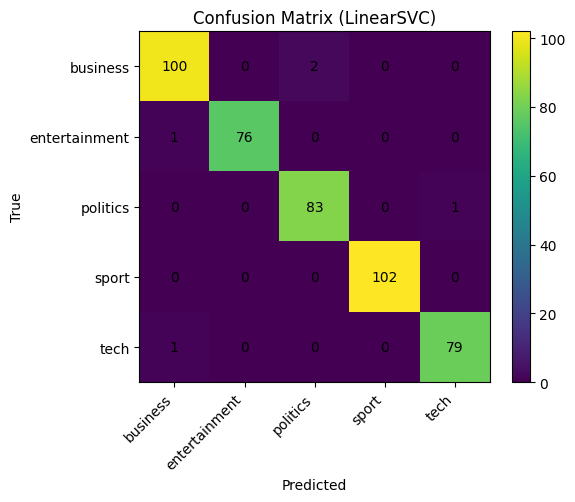

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9,
    sublinear_tf=True
)

Xtr = tfidf.fit_transform(train['text'])
Xte = tfidf.transform(test['text'])
ytr = train['label']
yte = test['label']

svm = LinearSVC()
svm.fit(Xtr, ytr)
pred_svm = svm.predict(Xte)
f1_svm = f1_score(yte, pred_svm, average='macro')

lr = LogisticRegression(max_iter=2000, solver='liblinear')
lr.fit(Xtr, ytr)
pred_lr = lr.predict(Xte)
f1_lr = f1_score(yte, pred_lr, average='macro')

print(f"Macro-F1  LinearSVC: {f1_svm:.3f}")
print(f"Macro-F1  LogReg   : {f1_lr:.3f}")

best_name, best_pred, best_model = (
    ("LinearSVC", pred_svm, svm) if f1_svm >= f1_lr else ("LogReg", pred_lr, lr)
)
print("Best model:", best_name)

print("\nClassification report:\n")
print(classification_report(yte, best_pred, digits=3))

cm = confusion_matrix(yte, best_pred, labels=labels)

plt.figure(figsize=(6,5))
im = plt.imshow(cm, interpolation="nearest")
plt.title(f"Confusion Matrix ({best_name})")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar(im)
plt.tight_layout()
plt.show()


In [20]:
from pathlib import Path
import joblib

Path('data/bbc_cls').mkdir(parents=True, exist_ok=True)
out = test.copy()
out['pred'] = best_pred
out.to_csv('data/bbc_cls/baseline_preds.csv', index=False)

with open('data/bbc_cls/baseline_report.txt','w') as f:
    f.write(classification_report(yte, best_pred, digits=3))

Path('data/models').mkdir(parents=True, exist_ok=True)
joblib.dump({'vectorizer': tfidf, 'model': best_model, 'labels': labels},
            'data/models/baseline_tfidf.joblib')

print("Saved:")
print("- data/bbc_cls/baseline_preds.csv")
print("- data/bbc_cls/baseline_report.txt")
print("- data/models/baseline_tfidf.joblib")

Saved:
- data/bbc_cls/baseline_preds.csv
- data/bbc_cls/baseline_report.txt
- data/models/baseline_tfidf.joblib


In [25]:
from google.colab import files
files.download('data/bbc_cls/baseline_preds.csv')
files.download('data/bbc_cls/baseline_report.txt')
files.download('data/models/baseline_tfidf.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>